## Compute Laplacian

In [2]:
## IMPORT LIBRARIES 
import os
import sys
import igl
import time
import torch
import numpy as np
import meshplot as mp
from typing import Tuple
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

## IMPORT SOURCE
from smpl_torch_batch import SMPLModel

In [3]:
## LOAD ANIMATION DATA (ORIGINAL SCANS OF SINGLE INSTANCE)

training_data = torch.load('../data/50004_dataset.pt')
data_loader = torch.utils.data.DataLoader(training_data, batch_size=1, shuffle=False)

device = "cpu"
smpl_model = SMPLModel(device=device, model_path='../body_models/smpl/female/model.pkl')

for data in data_loader:
    target_verts = data[1].squeeze()
    V = np.array(target_verts, dtype=float)
    F = np.array(smpl_model.faces, dtype=int)
    break

with np.load("../results/eigdecomp_batch.npz") as file:
    V_selected = file['arr_0']
    eigvals = file['arr_3']
    eigvecs = file['arr_4']
    

## Experiments

In [4]:
def generate_sine_wave(
    amplitude: float,
    frequency: float,
    phase: float,
    sampling_rate: int,
    duration: float) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
    """Generates a sine wave

    Args:
        amplitude (float): Amplitude
        frequency (float): Frequnecy [Hz]
        phase (float): Phase [rad]
        sampling_rate (int): Sampling rate[Hz]
        duration (float): Duration [s]

    Returns:
        Tuple[torch.FloatTensor, torch.FloatTensor]: t, y(t)
    """
    total_steps = int(sampling_rate * duration)
    t = torch.linspace(0, duration, total_steps)
    y = amplitude * torch.sin(2 * np.pi * frequency * t + phase)

    return t, y

In [5]:
def get_fft_components(signal, fourier, sampling_rate = 1_000, plot=True):
    absolutes = fourier.abs()
    freq = torch.fft.rfftfreq(len(signal), 1/sampling_rate)
    
    if plot:
        fig, ax = plt.subplots()
        ax.set_xlabel('Frequencies')
        ax.set_ylabel('$|F(s)|$')
        ax.grid()
        ax.scatter(x=freq, y=absolutes, s=8)
        plt.savefig('./plots/fourier_transform_sampling_{}_{}.png'.format(sampling_rate, time.time()))
    
    return absolutes, freq

In [6]:
V_tensor = torch.from_numpy(V_selected)
eigvals_tensor = torch.from_numpy(eigvals.real)
eigvecs_tensor = torch.from_numpy(eigvecs.real)

print(V_tensor.shape, eigvals_tensor.shape, eigvecs_tensor.shape)

torch.Size([7, 6890, 3]) torch.Size([7, 10]) torch.Size([7, 6890, 10])


In [23]:
###### FFT Computation (Naive)

duration = period = V_tensor.shape[0]
num_verts = V_tensor.shape[1]
dims = V_tensor.shape[2]
num_eigvals = eigvals.shape[1]

eigvecs_freqs = []
for frame in range(duration):
    eigvecs_abs = []
    eigdecomp_anim = []
    for eigval_idx in range(num_eigvals):
       
        signal = eigvecs_tensor[frame, :, eigval_idx]
        
        signal_fourier = torch.fft.rfft(signal, norm='forward') 
        absolutes, freqs = get_fft_components(signal, signal_fourier, plot=False)

        eigvecs_freqs.append(freqs)
        eigvecs_abs.append(absolutes)
    
    print(">> Frame ", frame+1 , "/", duration)
    eigdecomp_anim.append((eigvecs_freqs, eigvecs_abs))

>> Frame  1 / 7
>> Frame  2 / 7
>> Frame  3 / 7
>> Frame  4 / 7
>> Frame  5 / 7
>> Frame  6 / 7
>> Frame  7 / 7


In [8]:
#for i in range(period):
#    plt.plot(eigvals.real[i])

In [24]:
print(eigvecs_abs[0].shape, eigvecs_freqs[0].shape)
print(len(eigvecs_abs), len(eigvecs_freqs))

torch.Size([3446]) torch.Size([3446])
10 70


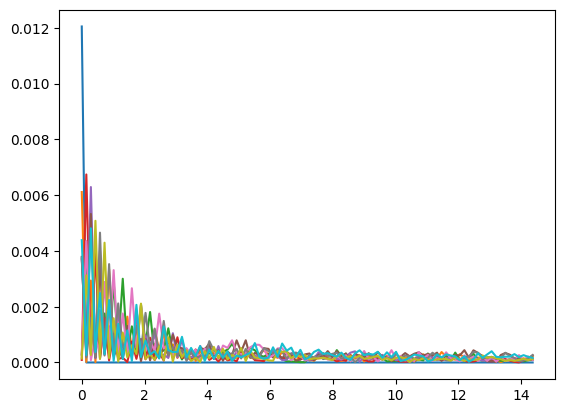

In [25]:
max_eig_components = 100

for i in range(num_eigvals):
    plt.plot(eigvecs_freqs[i][0:max_eig_components], eigvecs_abs[i][0:max_eig_components])
    

In [ ]:
# PLOT THE ADDED JIGGLING ANIMATION

v_start = V_selected[0]
p = mp.plot(v_start, F)
anim_length = V_selected.shape[0]

for k in range(10):
    for i in range(anim_length):
        
        v_new = V_selected[i]
        p.update_object(vertices=v_new)
        v = v_new
        time.sleep(0.1)